# Similarity Queries using Annoy Tutorial

This tutorial is about using the [Annoy(Approximate Nearest Neighbors Oh Yeah)]((https://github.com/spotify/annoy "Link to annoy repo") library for similarity queries in gensim

## Why use Annoy?
The current implementation for finding k nearest neighbors in a vector space in gensim has linear complexity via brute force in the number of indexed documents, although with extremely low constant factors. The retrieved results are exact, which is an overkill in many applications: approximate results retrieved in sub-linear time may be enough. Annoy can find approximate nearest neighbors much faster.
#### Comparing the traditional implementation and the Annoy  

In [1]:
#Set up the model and vector that we are using in the comparison
from gensim.similarities.index import AnnoyIndexer
from gensim.models.word2vec import Word2Vec

model = Word2Vec.load("/tmp/leemodel")
model.init_sims()
vector = model.syn0norm[0]
annoy_index = AnnoyIndexer(model, 500)

In [2]:
%%time
#Traditional implementation:
model.most_similar([vector], topn=5)

CPU times: user 4 ms, sys: 0 ns, total: 4 ms
Wall time: 1.34 ms


[('the', 0.9999999403953552),
 ('on', 0.9999382495880127),
 ('two', 0.9999366998672485),
 ('world', 0.9999361038208008),
 ('an', 0.9999345541000366)]

In [3]:
%%time
#Annoy implementation:
neighbors = model.most_similar([vector], topn=5, indexer=annoy_index)
for neighbor in neighbors:
    print neighbor

('the', 1.0)
('on', 0.9944407725706697)
('two', 0.9943768098019063)
('world', 0.9943451005965471)
('an', 0.9942796020768583)
CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 886 µs


A similarity query using Annoy is significantly faster than using the traditional brute force method
>**Note**: Initialization time for the annoy indexer was not included in the times. The optimal knn algorithm for you to use will depend on how many queries you need to make and the size of the corpus. If you are making very few similarity queries, the time taken to initialize the annoy indexer will be longer than the time it would take the brute force method to retrieve results. If you are making many queries however, the time it takes to initialize the annoy indexer will be made up for by the incredibly fast retrieval times for queries once the indexer has been initialized

## What is Annoy?

Annoy is an open source library to search for points in space that are close to a given query point. It also creates large read-only file-based data structures that are mmapped into memory so that many processes may share the same data. For our purpose, it is used to find similarity between words or documents in a vector space. [See the tutorial on similarity queries for more information on them](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/Similarity_Queries.ipynb).

## Getting Started

First thing to do is to install annoy, by running the following in the command line:

`sudo pip install annoy`

And then set up the logger: 

In [4]:
# import modules & set up logging
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

## Making a Similarity Query

For the following examples, we'll use the Lee Corpus (which you already have if you've installed gensim)

See the [Word2Vec tutorial](https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/word2vec.ipynb) for how to initialize and save this model.

In [5]:
# Load the model
import gensim
model = gensim.models.Word2Vec.load('/tmp/leemodel')
print model

Word2Vec(vocab=1723, size=100, alpha=0.025)


### Creating an indexer
An instance of `AnnoyIndexer` needs to be created in order to use Annoy in gensim. The `AnnoyIndexer` class is located in `gensim.similarities.index`

`AnnoyIndexer()` takes two parameters:

**`model`**: A w`Word2Vec` or `Doc2Vec` model

**`num_trees`**: A positive integer. `num_trees` effects the build time and the index size. **A larger value will give more accurate results, but larger indexes**. More information on what trees in Annoy do can be found [here](https://github.com/spotify/annoy#how-does-it-work). The relationship between `num_trees`, build time, and accuracy will be investigated later in the tutorial. 


In [6]:
from gensim.similarities.index import AnnoyIndexer
# 100 trees are being used in this example
annoy_index = AnnoyIndexer(model,100)

Now that we are ready to make a query, lets find the top 5 most similar words to "army" in the lee corpus. To make a similarity query we call `Word2Vec.most_similar` like we would traditionally, but with an added parameter, `indexer`. The only supported indexer in gensim as of now is Annoy. 

In [7]:
# Derive the vector for the word "army" in our model
vector = model["army"]
# The instance of AnnoyIndexer we just created is passed 
approximate_neighbors = model.most_similar([vector], topn=5, indexer=annoy_index)
# Neatly print the approximate_neighbors and their corresponding cosine similarity values
for neighbor in approximate_neighbors:
    print neighbor

('which', 0.9894100921228528)
('an', 0.9893329823389649)
('on', 0.9891384858638048)
('police', 0.9889771118760109)
('just', 0.9888260643929243)


### Analyzing the results

The closer the cosine similarity of a vector is to 1, the more similar that word is to our query, which was the vector for "army".

# Relationship between num_trees and initialization time

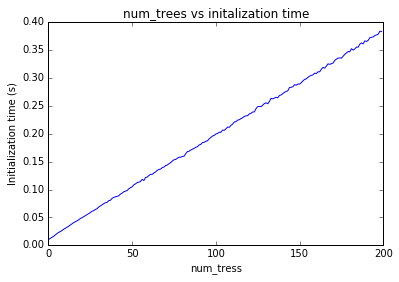

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt, time
x_cor = []
y_cor = []
for x in range(200):
    start_time = time.time()
    AnnoyIndexer(model, x)
    y_cor.append(time.time()-start_time)
    x_cor.append(x)

plt.plot(x_cor, y_cor)
plt.title("num_trees vs initalization time")
plt.ylabel("Initialization time (s)")
plt.xlabel("num_tress")
plt.show()

Initialization time of the annoy indexer increases in a linear fashion with num_trees. Initialization time will vary from corpus to corpus, in the graph above the lee corpus was used

# Relationship between num_trees and accuracy

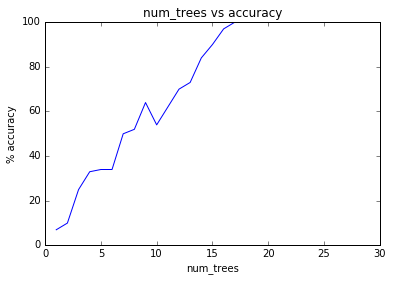

In [9]:
exact_results = [element[0] for element in model.most_similar([model.syn0norm[0]], topn=100)]
x_axis = []
y_axis = []
for x in range(1,30):
    annoy_index = AnnoyIndexer(model, x)
    approximate_results = model.most_similar([model.syn0norm[0]],topn=100, indexer=annoy_index)
    top_words = [result[0] for result in approximate_results]
    x_axis.append(x)
    y_axis.append(len(set(top_words).intersection(exact_results)))
    
plt.plot(x_axis, y_axis)
plt.title("num_trees vs accuracy")
plt.ylabel("% accuracy")
plt.xlabel("num_trees")
plt.show()

This was again done with the lee corpus, a relatively small corpus. Results will vary from corpus to corpus